In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, medfilt
from scipy.optimize import bisect
from scipy import stats
import pandas as pd
import seaborn as sns
import os
import cline_analysis as ca  # Your custom module
import requests
from io import StringIO
import datetime

In [2]:
# Load CSV files locally
# Filenames must be in format NAME_YYYYMMDD.csv (e.g. Jurua_19871012.csv)
fnames = ['Jurua_19871012.csv', 'Jurua_20170710.csv']
csv_dir = './csv_files/'  # relative to this notebook's folder

clxs, clys, rbxs, lbxs, rbys, lbys, curvatures, ages, widths, dates = [], [], [], [], [], [], [], [], [], []

for fname in fnames:
    filepath = os.path.join(csv_dir, fname)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"CSV file not found: {filepath}")
    df = pd.read_csv(filepath)
    
    # Extract data (matching loaddata() logic)
    x = df['centerline_x'].to_numpy()
    y = df['centerline_y'].to_numpy()
    lbx = df['right_bank_x'].to_numpy()  # right/left columns in this CSV
    rbx = df['left_bank_x'].to_numpy()
    lby = df['right_bank_y'].to_numpy()
    rby = df['left_bank_y'].to_numpy()
    
    clxs.append(x); clys.append(y)
    rbxs.append(rbx); lbxs.append(lbx)
    rbys.append(rby); lbys.append(lby)
    curvatures.append(df['curvature'].to_numpy())
    widths.append(df['width (m)'].values)

    # Extract year/month/day from filename (indices assume NAME_YYYYMMDD.csv)
    try:
        year = int(fname[6:10])
        month = int(fname[10:12])
        day = int(fname[12:14])
    except Exception as e:
        raise ValueError(f"Filename does not match expected format NAME_YYYYMMDD.csv: {fname}") from e

    ages.append(year)
    dates.append(datetime.datetime(year, month, day))

print("Files:", fnames)
print("Dates:", dates)
print("Num timesteps:", len(clxs))

Files: ['Jurua_19871012.csv', 'Jurua_20170710.csv']
Dates: [datetime.datetime(1987, 10, 12, 0, 0), datetime.datetime(2017, 7, 10, 0, 0)]
Num timesteps: 2


## Plot centerlines

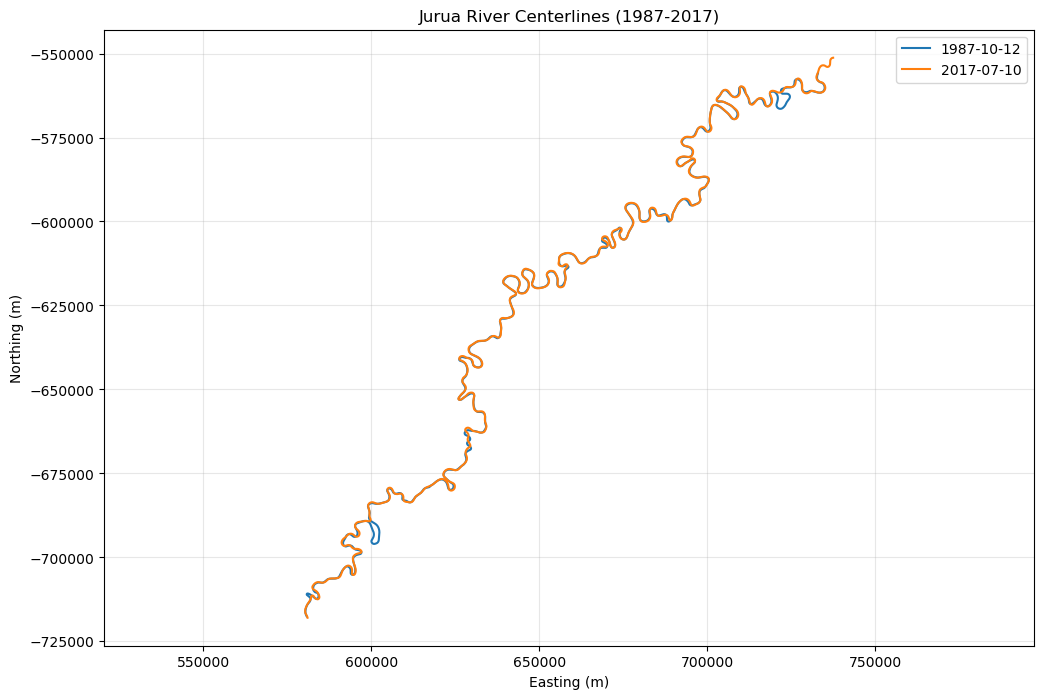

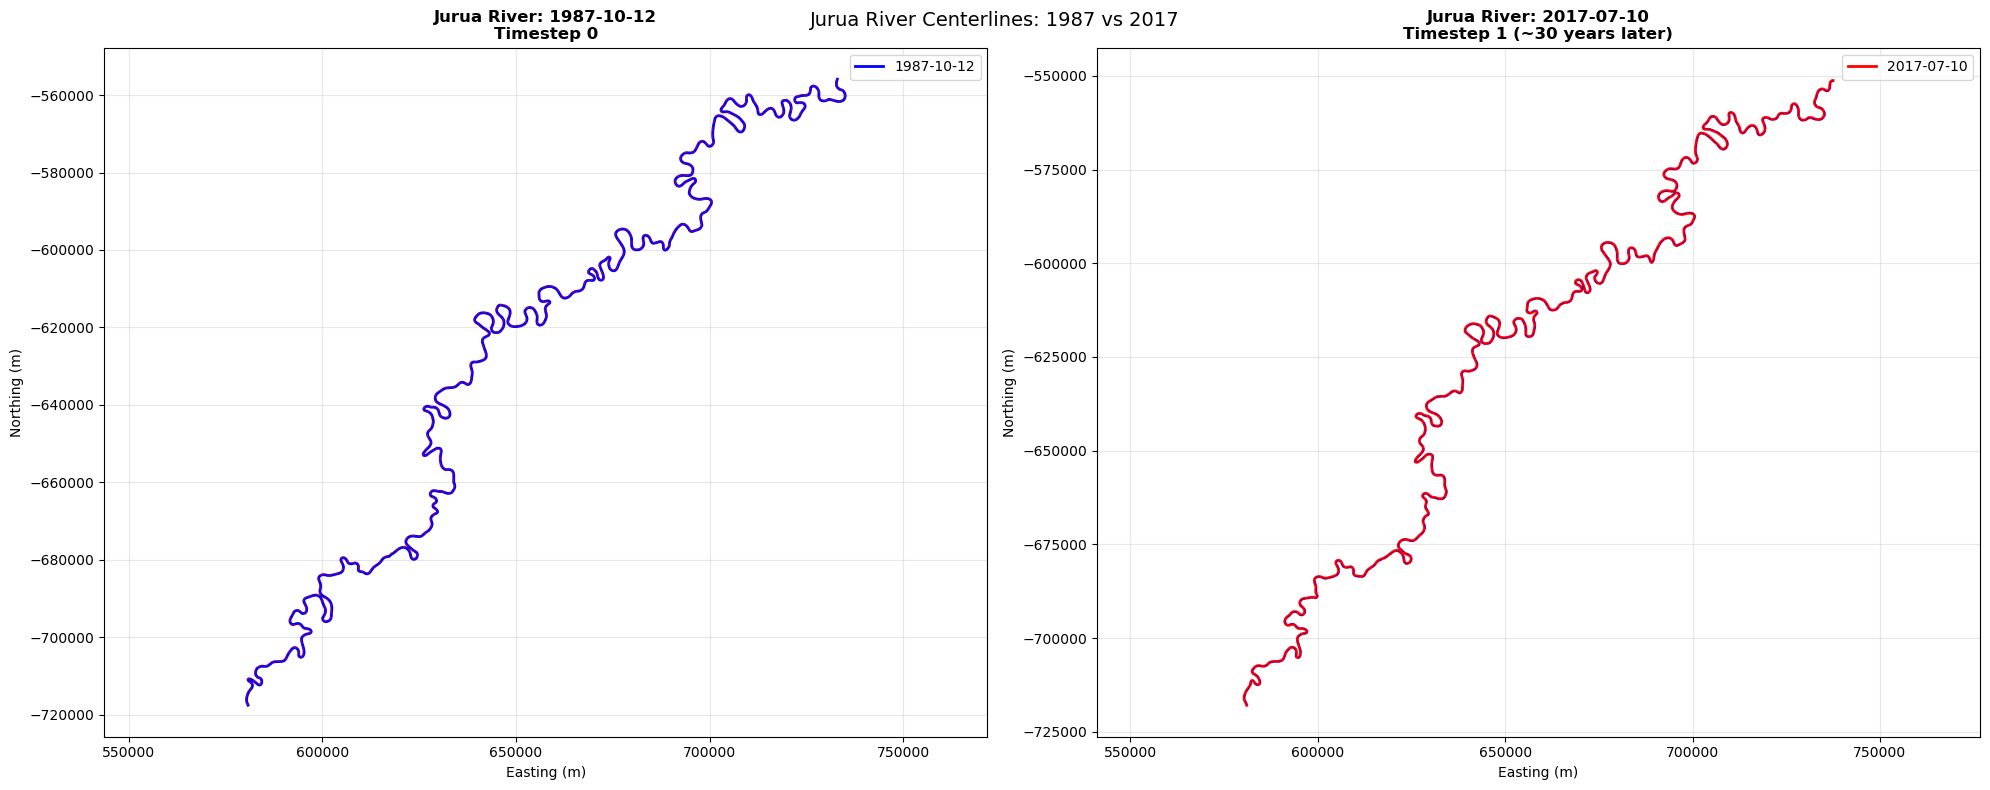

In [3]:
plt.figure(figsize=(12, 8))
for i in range(len(clxs)):
    x = np.array(clxs[i]); y = np.array(clys[i])
    plt.plot(x, y, '-', label=f'{dates[i].strftime("%Y-%m-%d")}', linewidth=1.5)
plt.axis('equal')
plt.title('Jurua River Centerlines (1987-2017)')
plt.xlabel('Easting (m)'); plt.ylabel('Northing (m)')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Subplots of each
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Timestep 0 (1987-10-12)
x0 = np.array(clxs[0]); y0 = np.array(clys[0])
ax1.plot(x0, y0, 'b-', linewidth=2, label='1987-10-12')
ax1.plot(np.array(rbxs[0]), np.array(rbys[0]), 'b--', alpha=0.5, linewidth=1)  # Right bank
ax1.plot(np.array(lbxs[0]), np.array(lbys[0]), 'r--', alpha=0.5, linewidth=1)  # Left bank
ax1.axis('equal')
ax1.set_title('Jurua River: 1987-10-12\nTimestep 0', fontsize=12, fontweight='bold')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.legend(); ax1.grid(True, alpha=0.3)

# Timestep 1 (2017-07-10) 
x1 = np.array(clxs[1]); y1 = np.array(clys[1])
ax2.plot(x1, y1, 'r-', linewidth=2, label='2017-07-10')
ax2.plot(np.array(rbxs[1]), np.array(rbys[1]), 'b--', alpha=0.5, linewidth=1)
ax2.plot(np.array(lbxs[1]), np.array(lbys[1]), 'r--', alpha=0.5, linewidth=1)
ax2.axis('equal')
ax2.set_title('Jurua River: 2017-07-10\nTimestep 1 (~30 years later)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Jurua River Centerlines: 1987 vs 2017', fontsize=14, y=0.98)
plt.show()

## Compute Curvature

- curvature = $|dx*ddy - dy*ddx| / (dx²+dy²)^1.5$
- Smoothing: SavGol (71-window, same as Mamore)
- For simulation: Primary driver - erosion ∝ curv

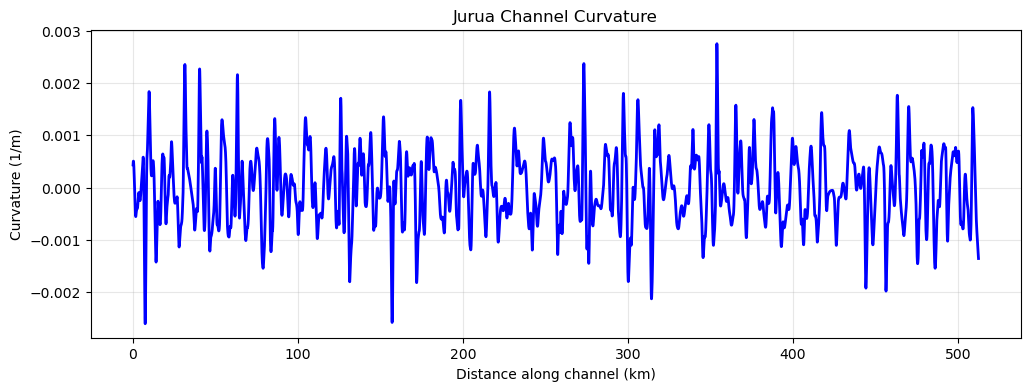

In [4]:
curv, s_curv = ca.compute_curvature(x, y)
curv = medfilt(savgol_filter(curv, 71, 3), kernel_size=5)

plt.figure(figsize=(12, 4))
plt.plot(s_curv/1000, curv, 'b-', linewidth=2, label='Curvature (1/m)')
plt.xlabel('Distance along channel (km)')
plt.ylabel('Curvature (1/m)')
plt.title('Jurua Channel Curvature')
plt.grid(True, alpha=0.3)
plt.show()


## Inflection / Zero Migration Points 

- Problem bends: 13 erodibility + 24 cutoff indices (more than Mamore)
- Shading: Gray=valid, pink=low erodibility, green=cutoffs
- Y-limits: Curvature (-1.0 to 0.5), Migration (-15 to 35 m/yr)
- For simulation: Validate individual bend evolution, measure lag LZM-LZC

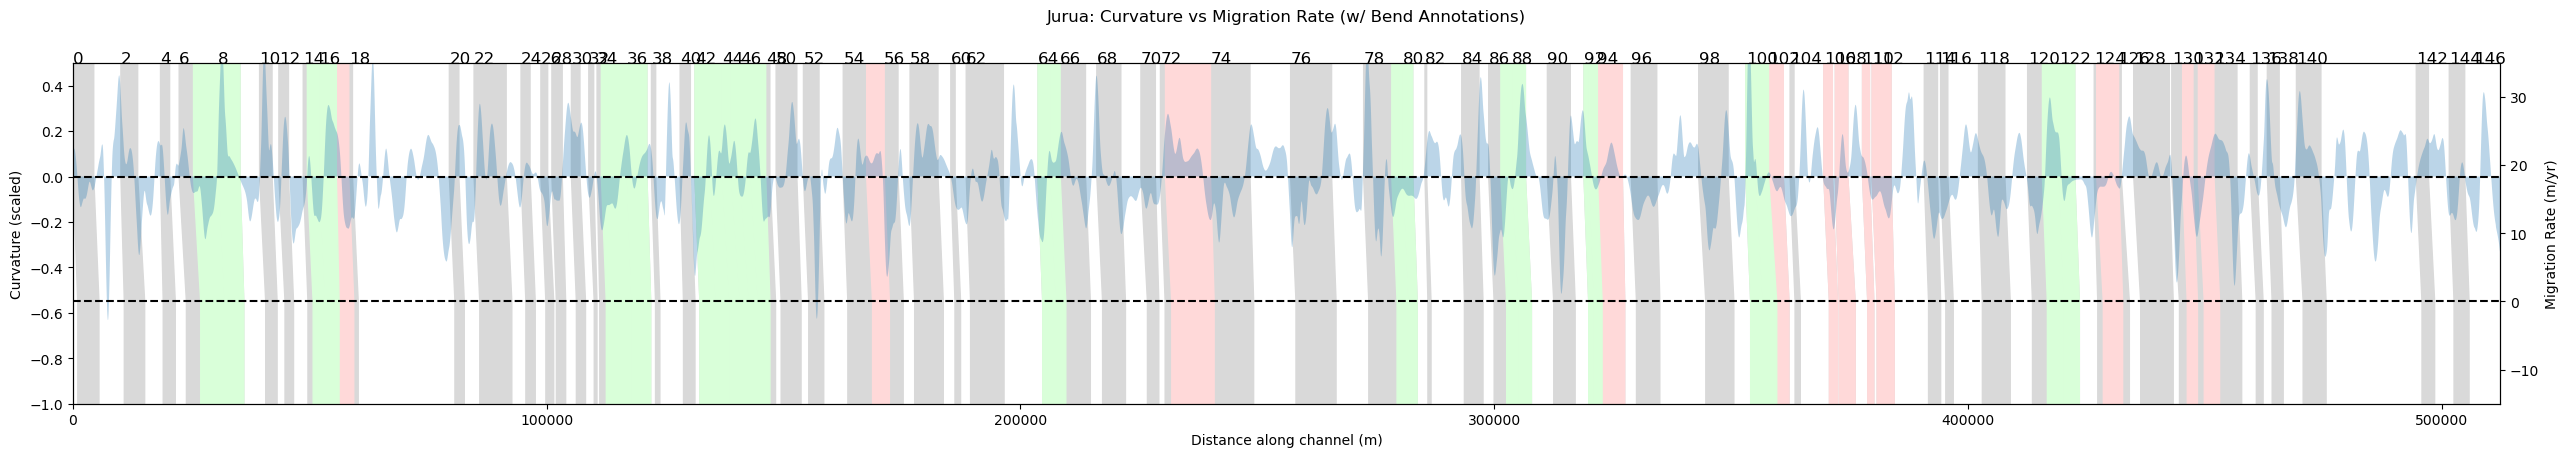

In [5]:
# Jurua-specific CSV
df = pd.read_csv('Jurua_LC08_L1TP_002064_20170710_20170725_01_T1_inflection_and_zero_migration_indices.csv')
LZC = np.array(df['index of inflection point'])  # Curvature zero-crossings
LZM = np.array(df['index of zero migration'])

# Jurua-specific problematic bends
erodibility_inds = [17,55,73,94,102,106,108,110,112,125,131,133]
cutoff_inds = [7,8,15,16,35,36,42,43,44,45,46,47,64,65,79,80,87,88,92,93,100,101,121,122]

# Use s_curv as s (distance along channel), fallback to np.arange(len(curv))
if 's_curv' in globals():
    s = s_curv
elif 's_curv' in locals():
    s = s_curv
elif 'curv' in globals():
    s = np.arange(len(curv))
elif 'curv' in locals():
    s = np.arange(len(curv))
else:
    raise ValueError('curv or s_curv must be defined before running this cell.')

# Dummy migration rate if not defined
if 'migrrate' not in globals() and 'migrrate' not in locals():
    migrrate = np.zeros_like(s)

W = np.nanmean(widths[0]) if 'widths' in globals() or 'widths' in locals() else 1.0  # timestep 0 widths
fig, ax1 = plt.subplots(figsize=(25, 4)); plt.tight_layout()

y1, y2, y3, y4 = 0.5, 0.0, -0.55, -1.0

# Shade valid bends (avoid out-of-bounds)
n = len(s)
for i in range(0, len(LZC)-1, 2):
    inds = [LZC[i], LZC[i+1], LZM[i], LZM[i+1]]
    if all(0 <= idx < n for idx in inds):
        xcoords = [s[LZC[i]], s[LZC[i+1]], s[LZC[i+1]], s[LZM[i+1]], s[LZM[i+1]], 
                   s[LZM[i]], s[LZM[i]], s[LZC[i]]]
        ycoords = [y1,y1,y2,y3,y4,y4,y3,y2]
        ax1.fill(xcoords, ycoords, color=(0.85,0.85,0.85), zorder=0)

# Plot data
ax1.fill_between(s, 0, curv*W, alpha=0.3)
ax2 = ax1.twinx()
ax2.fill_between(s, 0, migrrate, facecolor='green', alpha=0.5)
ax1.plot([0, max(s)], [0, 0], 'k--')
ax2.plot([0, max(s)], [0, 0], 'k--')

ax1.set_ylim(y4, y1); ax2.set_ylim(-15, 35)
ax1.set_xlim(0, s[-1])

# Highlight problem areas
for i in erodibility_inds:
    if i+1 < len(LZC) and i+1 < len(LZM):
        inds = [LZC[i], LZC[i+1], LZM[i], LZM[i+1]]
        if all(0 <= idx < n for idx in inds):
            xcoords = [s[LZC[i]], s[LZC[i+1]], s[LZC[i+1]], s[LZM[i+1]], s[LZM[i+1]], 
                       s[LZM[i]], s[LZM[i]], s[LZC[i]]]
            ycoords = [y1,y1,y2,y3,y4,y4,y3,y2]
            ax1.fill(xcoords, ycoords, color=(1.0,0.85,0.85), zorder=0)

for i in cutoff_inds:
    if i+1 < len(LZC) and i+1 < len(LZM):
        inds = [LZC[i], LZC[i+1], LZM[i], LZM[i+1]]
        if all(0 <= idx < n for idx in inds):
            xcoords = [s[LZC[i]], s[LZC[i+1]], s[LZC[i+1]], s[LZM[i+1]], s[LZM[i+1]], 
                       s[LZM[i]], s[LZM[i]], s[LZC[i]]]
            ycoords = [y1,y1,y2,y3,y4,y4,y3,y2]
            ax1.fill(xcoords, ycoords, color=(0.85,1.0,0.85), zorder=0)

# Label bends
for i in range(0, len(LZC)-1, 2):
    if 0 <= LZC[i] < n:
        ax1.text(s[LZC[i]], 0.5, str(i), fontsize=12)

ax1.set_xlabel('Distance along channel (m)')
ax1.set_ylabel('Curvature (scaled)'); ax2.set_ylabel('Migration Rate (m/yr)')
plt.title('Jurua: Curvature vs Migration Rate (w/ Bend Annotations)', pad=30)
plt.show()
